# Cold Diffusion

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
import copy
import math
from tqdm.notebook import trange, tqdm
from PIL import Image

from diffusers.models import AutoencoderKL

In [2]:
# training parameters
batch_size = 32
lr = 2e-5

train_epoch = 1200

# data_loader
latent_size = 32

data_set_root = "../../datasets"

<b> Use a GPU if avaliable </b>

In [3]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 1
device = torch.device(gpu_indx if use_cuda else "cpu")

In [4]:
class LatentDataset(Dataset):
    def __init__(self, latent_dir):
        self.latent_dir = latent_dir
        self.latent_files = sorted(os.listdir(latent_dir))

    def __len__(self):
        return len(self.latent_files)

    def __getitem__(self, idx):
        latent_file = self.latent_files[idx]
        latent = np.load(os.path.join(self.latent_dir, latent_file))
        return torch.tensor(latent)

In [5]:
data_set_root = "/media/luke/Quick_Storage/Data/CelebAHQ/image_latents"
trainset = LatentDataset(data_set_root)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded


def reconstruct_image(patch_sequence, image_shape, patch_size=8):
    """
    Reconstructs the original image tensor from a sequence of patches.

    Args:
        patch_sequence (torch.Tensor): Sequence of patches with shape BSxLxCxpatch_size x patch_size.
        image_shape (tuple): Shape of the original image tensor (bs, c, h, w).
        patch_size (int): Size of the patches used in extraction.

    Returns:
        torch.Tensor: Reconstructed image tensor.
    """
    bs, c, h, w = image_shape
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    
    # Reshape the patch sequence to match the unfolded tensor shape
    unfolded_shape = (bs, num_patches_h, num_patches_w, patch_size, patch_size, c)
    patch_sequence = patch_sequence.view(*unfolded_shape)
    
    # Transpose dimensions to match the original image tensor shape
    patch_sequence = patch_sequence.permute(0, 5, 1, 3, 2, 4).contiguous()
    
    # Reshape the sequence of patches back into the original image tensor shape
    reconstructed = patch_sequence.view(bs, c, h, w)
    
    return reconstructed

In [7]:
class ConditionalNorm2d(nn.Module):
    def __init__(self, hidden_size, num_features):
        super(ConditionalNorm2d, self).__init__()
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)

        self.fcw = nn.Linear(num_features, hidden_size)
        self.fcb = nn.Linear(num_features, hidden_size)

    def forward(self, x, features):
        bs, s, l = x.shape
        
        out = self.norm(x)
        w = self.fcw(features).reshape(bs, 1, -1)
        b = self.fcb(features).reshape(bs, 1, -1)

        return w * out + b

    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
# Transformer block with self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, num_features=128):
        # Initialize the parent nn.Module
        super(TransformerBlock, self).__init__()
        
        # Layer normalization to normalize the input data
        self.norm = nn.LayerNorm(hidden_size)
        
        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, 
                                                    batch_first=True, dropout=0.0)
        
        # Another layer normalization
        self.con_norm = ConditionalNorm2d(hidden_size, num_features)
        
        # Multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.LayerNorm(hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
                
    def forward(self, x, features):
        # Apply the first layer normalization
        norm_x = self.norm(x)
        
        # Apply multi-head attention and add the input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        # Apply the second layer normalization
        norm_x = self.con_norm(x, features)
        
        # Pass through the MLP and add the input (residual connection)
        x = self.mlp(norm_x) + x
        
        return x

    
# Define a Vision Encoder module for the Diffusion Transformer
class DiT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, 
                 hidden_size=128, num_features=128, 
                 num_layers=3, num_heads=4):
        super(DiT, self).__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(num_features),
            nn.Linear(num_features, 2 * num_features),
            nn.GELU(),
            nn.Linear(2 * num_features, num_features),
            nn.GELU()
        )
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, channels_in * patch_size * patch_size)
                
    def forward(self, image_in, index):  
        # Get timestep embedding
        index_features = self.time_mlp(index)

        # Split input into patches
        patch_seq = extract_patches(image_in, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # Pass the embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs, index_features)
        
        # Project to output
        image_out = self.fc_out(embs)
        
        # Reconstruct the input from patches and return result
        return reconstruct_image(image_out, image_in.shape, patch_size=self.patch_size)


## Cosine schedual

In [8]:
def cosine_alphas_bar(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, steps, steps)
    alphas_bar = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    return alphas_bar[:timesteps]

## Reverse Cold Diffusion Process 
We're implementing DDIM, specifically cold diffusion, which can use any transformation, however we are just doing de-noising.

[Cold Diffusion](https://arxiv.org/pdf/2208.09392.pdf)

In [9]:
def noise_from_x0(curr_img, img_pred, alpha):
    return (curr_img - alpha.sqrt() * img_pred)/((1 - alpha).sqrt() + 1e-4)

In [10]:
def cold_diffuse(diffusion_model, sample_in, total_steps, start_step=0):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    with torch.no_grad():
        for i in trange(start_step, total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise

            random_sample += rep2 - rep1

        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output


In [11]:
# Create a dataloader itterable object
dataiter = iter(train_loader)
# Sample from the itterable object
latents = next(dataiter)

In [12]:
timesteps = 500
patch_size = 2

# network
dit = DiT(latent_size, channels_in=latents.shape[1], patch_size=patch_size, 
            hidden_size=768, num_layers=10, num_heads=8).to(device)

# Adam optimizer
optimizer = optim.Adam(dit.parameters(), lr=lr)

# Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

alphas = torch.flip(cosine_alphas_bar(timesteps), (0,)).to(device)

In [13]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in dit.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 73194128 (Approximately 73 Million) Parameters!


In [14]:
loss_log = []
mean_loss = 0

In [15]:
# Load Checkpoint
cp = torch.load("latent_dit.pt")
dit.load_state_dict(cp["model_state_dict"])
optimizer.load_state_dict(cp["optimizer_state_dict"])
loss_log = cp["train_data_logger"]
start_epoch = cp["epoch"]

In [16]:
optimizer.param_groups[0]["lr"] = 5e-6

In [17]:
pbar = trange(start_epoch, train_epoch, leave=False, desc="Epoch")    
dit.train()
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (mean_loss/len(train_loader)))
    mean_loss = 0

    for num_iter, (latents) in enumerate(tqdm(train_loader, leave=False)):
        latents = latents.to(device)
        
        #the size of the current minibatch
        bs = latents.shape[0]

        rand_index = torch.randint(timesteps, (bs, ), device=device)
        random_sample = torch.randn_like(latents)
        alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)
        
        noise_input = alpha_batch.sqrt() * latents + (1 - alpha_batch).sqrt() * random_sample
        
        with torch.cuda.amp.autocast():
            latent_pred = dit(noise_input, rand_index)
            loss = F.l1_loss(latent_pred, latents)
        
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #log the generator training loss
        loss_log.append(loss.item())
        mean_loss += loss.item()

    # Quick save of the model every epoch
    torch.save({'epoch': epoch + 1,
                'train_data_logger': loss_log,
                'model_state_dict': dit.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                 }, "latent_dit.pt")

Epoch: 0it [00:00, ?it/s]

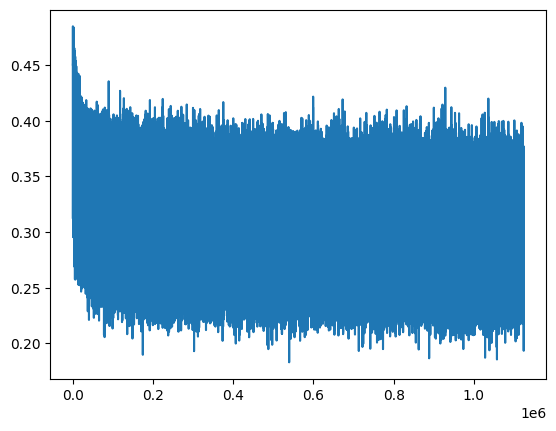

In [18]:
# Plot loss
plt.plot(loss_log[1000:])

In [19]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device)

/home/luke/Documents/vesuvius_venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
latent_noise = 0.95 * torch.randn(8, 4, latent_size, latent_size, device=device)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        fake_latents = cold_diffuse(dit, latent_noise, total_steps=timesteps)
        fake_sample = vae.decode(fake_latents / 0.18215).sample

  0%|          | 0/499 [00:00<?, ?it/s]

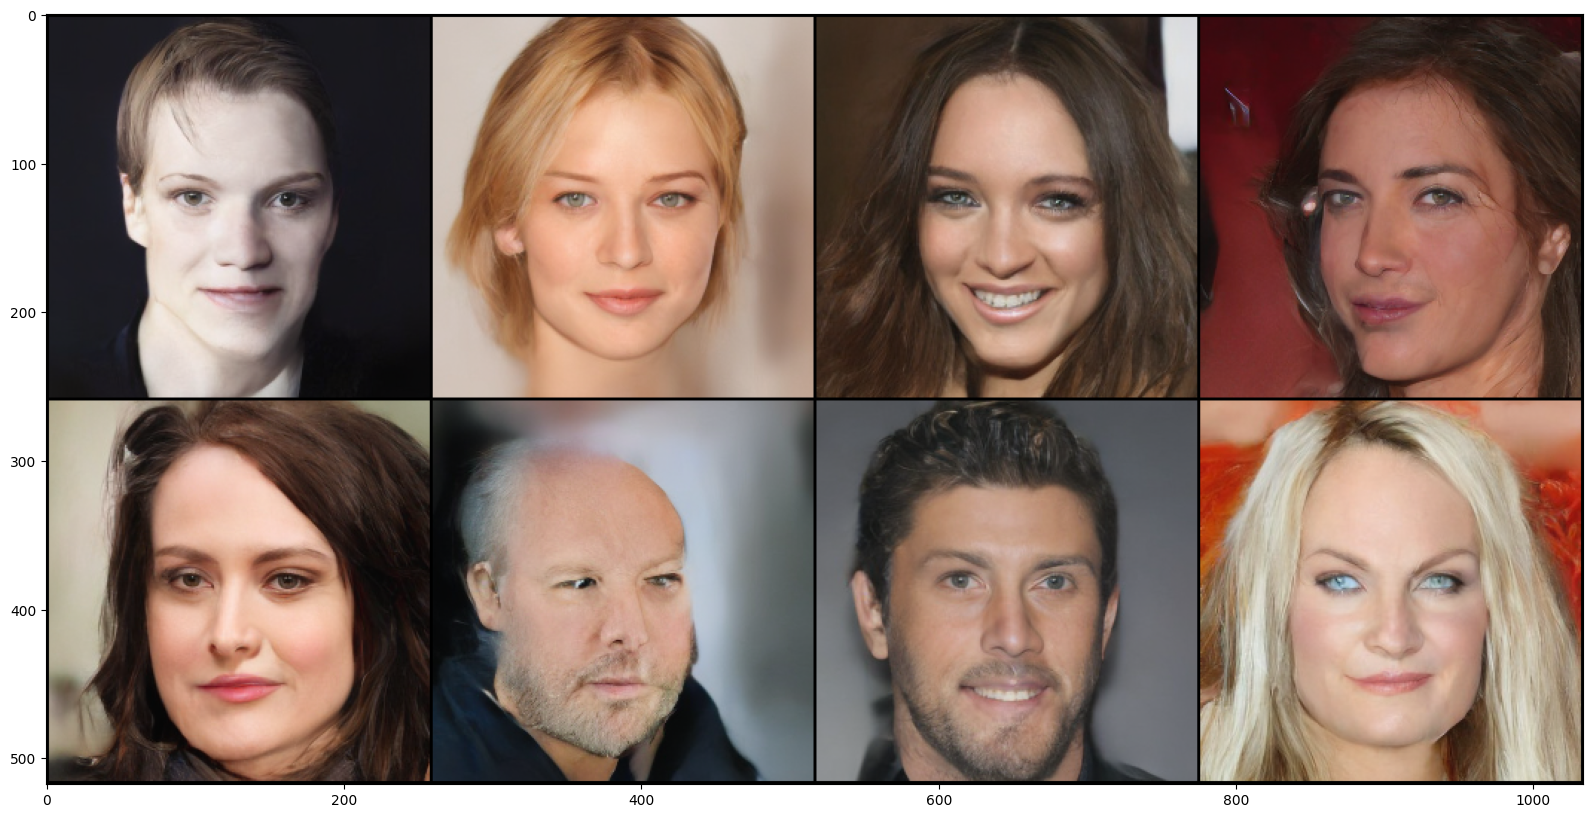

In [21]:
plt.figure(figsize = (20, 10))
out = vutils.make_grid(fake_sample.detach().float().cpu(), nrow=4, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Image to Image Diffusion

One benifit of Diffusion over other types of Image generation methods is the flexibility of the model once trained! One of the simplest techniques to show off this flexibility is seeding diffusion generation with an existing source image! That is, instead of starting with pure noise, we can start with an image that has been noised up via the forward process and use this as a starting point for generation! The more noise we add, the further the generated image will be from the source image!  

In [22]:
# Setup data:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])


In [24]:
# Load a test image!
test_img = Image.open("../data/obama.png")
test_tensor = transform(test_img).unsqueeze(0).to(device)

In [25]:
# How many different images to create
mini_batch_size = 8

# Where is the forward process to start from (0-499)
# The closer to the start (0) the more noise added to the source image!
index = 300

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        latent_noise = 0.95 * torch.randn_like(latents)

        alpha_batch = alphas[index].expand(mini_batch_size).reshape(mini_batch_size, 
                                                                    1, 1, 1)
        noise_input = alpha_batch.sqrt() * latents + (1 - alpha_batch).sqrt() * latent_noise
        
        fake_latents = cold_diffuse(dit, noise_input, 
                                    total_steps=timesteps, 
                                    start_step=index)
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

  0%|          | 0/199 [00:00<?, ?it/s]

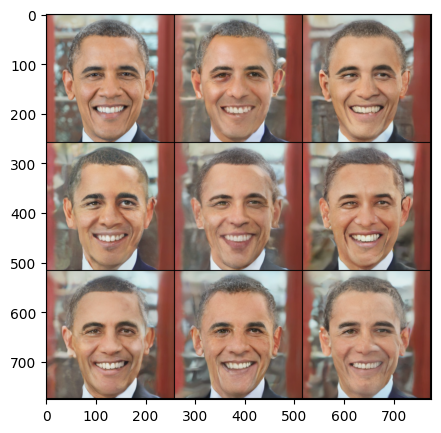

In [26]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Image In-Painting

A more advanced technique is known as "In-Painting", that is, painting (generating) over specific sections of a source image. To do this we essentially replace sections of the "image" (or latent representation) during the generation process with our target image (also noised up to match that step of the forward process). To do this we need to update our diffusion generation loop to include the target image (or latent) and the "mask". This "mask" in it's simplest form is a binary (1s and 0s) that define what section of the target image we want to keep and what section we want to remove!

In [48]:
def cold_diffuse_inpaint(diffusion_model, sample_in, target, mask, 
                         total_steps, start_step=0):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    
    with torch.no_grad():
        for i in trange(start_step, total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            # noising up the target to match the same step in the process
            noisy_target = alphas[i].sqrt() * target +\
            (1 - alphas[i]).sqrt() * torch.randn_like(target)
                
            # Use the mask to replace certain parts of the generation with the 
            # noisy target
            random_sample = mask * random_sample + (1 - mask) * noisy_target
            
            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise
            
            # The current latent in the diffusion generation process
            random_sample += rep2 - rep1
            
        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output


In [28]:
# Hard code a simple mask
# A value of 1 means that, that part will be replaced
# A value of 0 means that, that part will be kept
mask = torch.zeros(1, latent_size, latent_size, device=device)
mask[:, 8:latent_size-8, 8:latent_size-8] = torch.ones(16, 16, device=device)

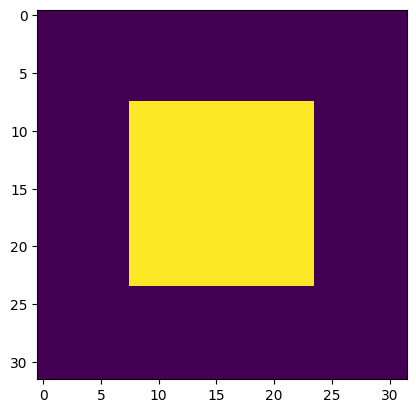

In [29]:
# We will simply replace a square region in the middle of the image!
_ = plt.imshow(mask[0].cpu().numpy())

In [55]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=mask)
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

  0%|          | 0/499 [00:00<?, ?it/s]

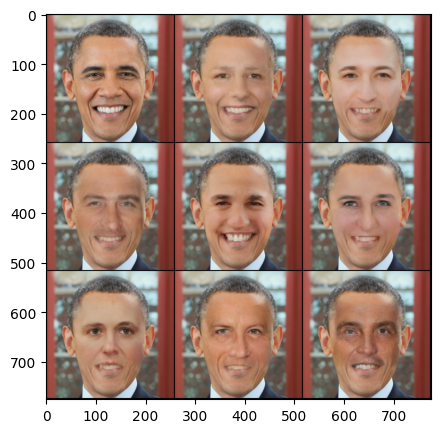

In [56]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Invert the mask

In [53]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=1 - mask)  # Invert the mask
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

  0%|          | 0/499 [00:00<?, ?it/s]

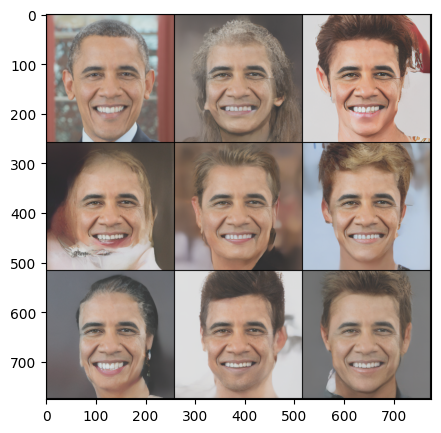

In [54]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Using a Smooth Mask

We can put a bit more effort into created a good mask from the origional target image. Once we downsample the mask to the correct size we will also get a gradient of values from 0 to 1 that will smoothly interpolate the target and generated portions of the image!

In [34]:
# Setup data:
mask_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [35]:
face_mask = Image.open("../data/ob_face_mask.png")
face_mask_tensor = mask_transform(face_mask).unsqueeze(0).to(device)

bg_mask = Image.open("../data/ob_bg_mask.png")
bg_mask_tensor = mask_transform(bg_mask).unsqueeze(0).to(device)

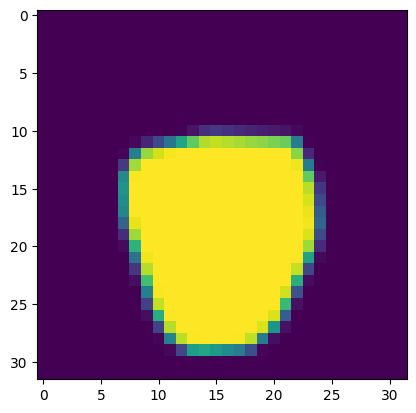

In [36]:
# Mask of just the face region!
_ = plt.imshow(face_mask_tensor[0, 0].cpu().numpy())

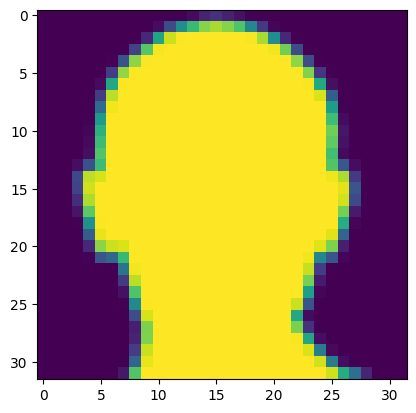

In [37]:
# Mask of the whole body
_ = plt.imshow(bg_mask_tensor[0, 0].cpu().numpy())

In [61]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=face_mask_tensor)
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

  0%|          | 0/499 [00:00<?, ?it/s]

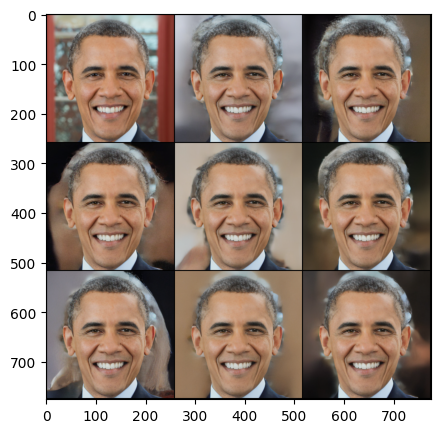

In [62]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))